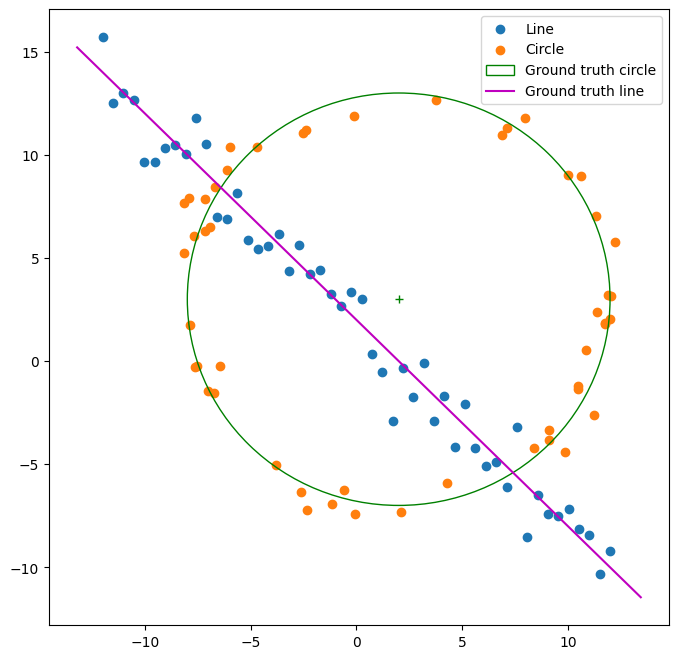

In [42]:
from scipy.optimize import minimize
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()

Number of inliers: 39
Mean error: 0.401206656149288


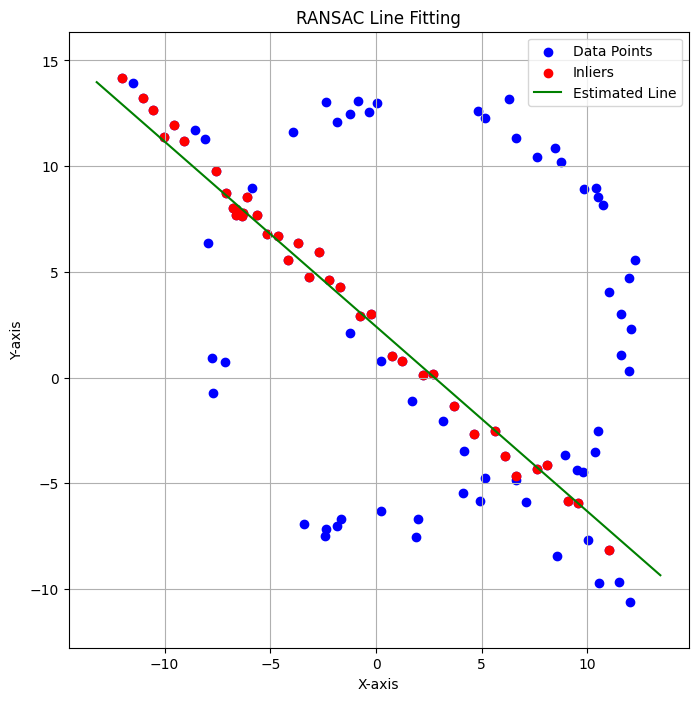

In [43]:
def ransac_line_fitting(points, num_iterations=1000, distance_threshold=1.0, consensus_threshold=50):
    best_model = None
    best_inliers = []

    for _ in range(num_iterations):
        # Randomly select 2 points
        sample_indices = np.random.choice(points.shape[0], 2, replace=False)
        sample_points = points[sample_indices]

        # Fit a line to these 2 points
        p1, p2 = sample_points
        a, b = p2 - p1
        norm = np.sqrt(a**2 + b**2)
        a, b = a / norm, b / norm  # Ensure the constraint ∥[a,b]⊺∥=1
        c = -a * p1[0] - b * p1[1]

        # Calculate the distance of all points to the line
        distances = np.abs(a * points[:, 0] + b * points[:, 1] + c)

        # Determine inliers
        inliers = points[distances < distance_threshold]

        # Update the best model if the current one has more inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (a, b, c)

        # Early exit if we have enough inliers
        if len(best_inliers) >= consensus_threshold:
            break

    return best_model, best_inliers

# Apply RANSAC to the combined points
best_model, best_inliers = ransac_line_fitting(all_points)

# Extract the line parameters
a, b, c = best_model

# Plot the points and the estimated line
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(all_points[:, 0], all_points[:, 1], label='Data Points', color='blue')
ax.scatter(best_inliers[:, 0], best_inliers[:, 1], label='Inliers', color='red')

# Plot the estimated line
x_vals = np.array(ax.get_xlim())
y_vals = -(a * x_vals + c) / b
ax.plot(x_vals, y_vals, color='green', label='Estimated Line')

# Print number of inliers and error (the normal distance to the estimated line)
num_inliers = len(best_inliers)
errors = np.abs(a * best_inliers[:, 0] + b * best_inliers[:, 1] + c)
mean_error = np.mean(errors)

print(f"Number of inliers: {num_inliers}")
print(f"Mean error: {mean_error}")

# Add the legend, title, and grid
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('RANSAC Line Fitting')
plt.grid()
plt.axis('equal')
plt.show()

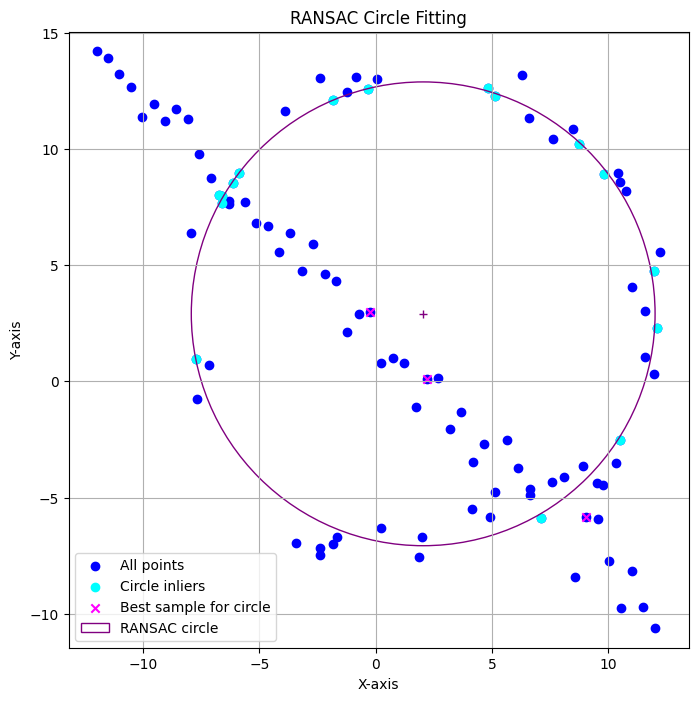

In [44]:
# Generate the figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all points
ax.scatter(all_points[:, 0], all_points[:, 1], color='blue', label='All points')

# Plot inliers for the circle
ax.scatter(remnant_points[circle_inliers, 0], remnant_points[circle_inliers, 1], color='cyan', label='Circle inliers')

# Plot the sample points that led to the best circle estimation
ax.scatter(best_circle_sample_points[:, 0], best_circle_sample_points[:, 1], color='magenta', marker='x', label='Best sample for circle')

# Plot the RANSAC circle
ransac_circle = plt.Circle((best_circle_model[0], best_circle_model[1]), best_circle_model[2], color='purple', fill=False, label='RANSAC circle')
ax.add_patch(ransac_circle)
ax.plot(best_circle_model[0], best_circle_model[1], '+', color='purple')

# Set axis limits and labels
ax.set_xlim([-14, 14])
ax.set_ylim([-14, 16])

# Add the legend, title, and grid
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('RANSAC Circle Fitting')
plt.grid()
plt.axis('equal')

# Show the plot
plt.show()

Number of inliers in the line: 16
Parameters of the estimated line:
a: 0.7080986693010423
b: 0.7061134997534697
d: 1.5303717301982513
Number of remnant points: 84
Number of inliers in the circle: 16
Parameters of the estimated circle:
x_center: 2.0388812056906938
y_center: 2.905374551155992
radius: 9.971739443086292


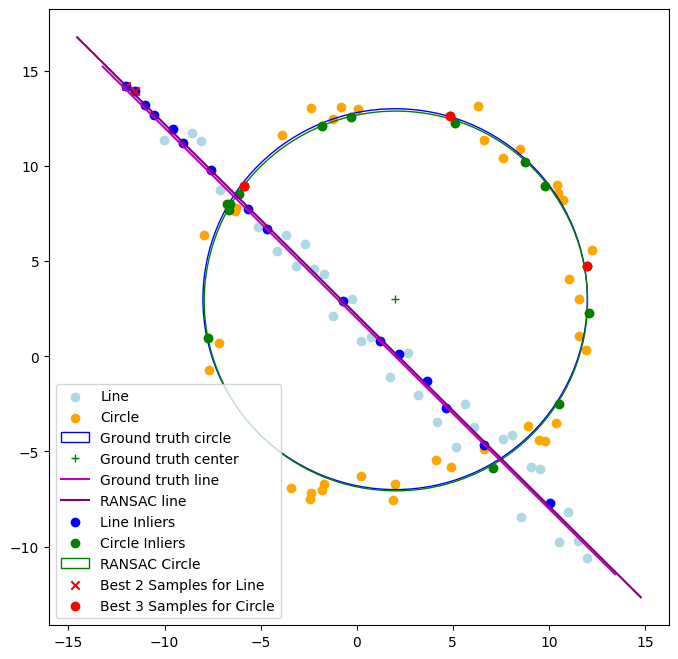

In [45]:
import numpy as np
import math
from scipy.optimize import minimize

import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(1)

N = 100
half_n = N // 2
radius = 10
circle_center_x, circle_center_y = 2, 3  # Center of the circle
circle_noise_scale = radius / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = circle_noise_scale * np.random.randn(half_n)
x_circle = circle_center_x + (radius + noise) * np.cos(theta)
y_circle = circle_center_y + (radius + noise) * np.sin(theta)

circle_points = np.column_stack((x_circle, y_circle))

# Generate points for the line
line_noise_scale = 1.0
line_slope, line_intercept = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = line_slope * x_line + line_intercept + line_noise_scale * np.random.randn(half_n)

line_points = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create all_points
all_points = np.vstack((circle_points, line_points))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(line_points[:, 0], line_points[:, 1], color='lightblue', label='Line')
ax.scatter(circle_points[:, 0], circle_points[:, 1], color='orange', label='Circle')
true_circle = plt.Circle((circle_center_x, circle_center_y), radius, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(true_circle)
ax.plot(circle_center_x, circle_center_y, '+g', label='Ground truth center')
x_min_val, x_max_val = ax.get_xlim()
x_range_vals = np.array([x_min_val, x_max_val])
y_range_vals = line_slope * x_range_vals + line_intercept
plt.plot(x_range_vals, y_range_vals, color='m', label='Ground truth line')

# Define a function to calculate the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(points, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(points), 2, replace=False)
        x1, y1 = points[sample_indices[0]]
        x2, y2 = points[sample_indices[1]]
        
        a, b, d = line_equation_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a * points[:, 0] + b * points[:, 1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters
iterations = 10000
line_threshold = 0.15
min_line_inliers = 15

# Estimate the line using RANSAC
best_line_model, line_inliers = ransac_line(line_points, iterations, line_threshold, min_line_inliers)

print("Number of inliers in the line:", len(line_inliers))
print("Parameters of the estimated line:")
print(f"a: {best_line_model[0]}")
print(f"b: {best_line_model[1]}")
print(f"d: {best_line_model[2]}")

# Define a function to calculate the circle equation from three points
def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    # Calculate the midpoints of two line segments
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    
    # Calculate the slopes of the two lines
    if y2 - y1 == 0:
        slope1 = 0  # Avoid division by zero
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0  # Avoid division by zero
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    # Calculate the center of the circle
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1
    
    # Calculate the radius
    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2)
    
    return x_center, y_center, radius

# RANSAC to fit a circle
def ransac_circle(points, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        x1, y1 = points[sample_indices[0]]
        x2, y2 = points[sample_indices[1]]
        x3, y3 = points[sample_indices[2]]
        
        x_center, y_center, radius = circle_equation_from_points(x1, y1, x2, y2, x3, y3)
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((points[:, 0] - x_center)**2 + (points[:, 1] - y_center)**2) - radius)
        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2
min_circle_inliers = 15

# Identify the remnant points (not explained by the line)
remnant_indices = [i for i in range(len(all_points)) if i not in line_inliers]
remnant_points = all_points[remnant_indices]

# Print the number of remnant points
print("Number of remnant points:", len(remnant_points))

# Estimate the circle using RANSAC
best_circle_model, circle_inliers = ransac_circle(remnant_points, circle_iterations, circle_threshold, min_circle_inliers)

print("Number of inliers in the circle:", len(circle_inliers))
print("Parameters of the estimated circle:")
print(f"x_center: {best_circle_model[0]}")
print(f"y_center: {best_circle_model[1]}")
print(f"radius: {best_circle_model[2]}")

# Plot the results

# Plot the estimated line
x_min_val, x_max_val = ax.get_xlim()
x_range_vals = np.array([x_min_val, x_max_val])
y_range_vals = (-best_line_model[0] * x_range_vals + best_line_model[2]) / best_line_model[1]
plt.plot(x_range_vals, y_range_vals, label='RANSAC line', color='purple')

ax.scatter(line_points[line_inliers, 0], line_points[line_inliers, 1], color='blue', label='Line Inliers')

# Find the best 2 samples for the line
best_line_sample_indices = line_inliers[:2]
best_line_samples = line_points[best_line_sample_indices]

# Plot the inliers of the circle
ax.scatter(remnant_points[circle_inliers, 0], remnant_points[circle_inliers, -1], color='g', label='Circle Inliers')

# Plot the estimated circle
x_center, y_center, radius = best_circle_model
estimated_circle = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(estimated_circle)

# Find the best 3 samples for the circle (using circle_inliers)
best_circle_sample_indices = circle_inliers[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]

# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')

plt.legend()
plt.show()

Number of inliers for the line: 16
Parameters of the estimated line:
a: 0.7080986693010423
b: 0.7061134997534697
d: 1.5303717301982513
Number of inliers for the circle: 16
Parameters of the estimated circle:
x_center: 2.0388812056906938
y_center: 2.905374551155992
radius: 9.971739443086292


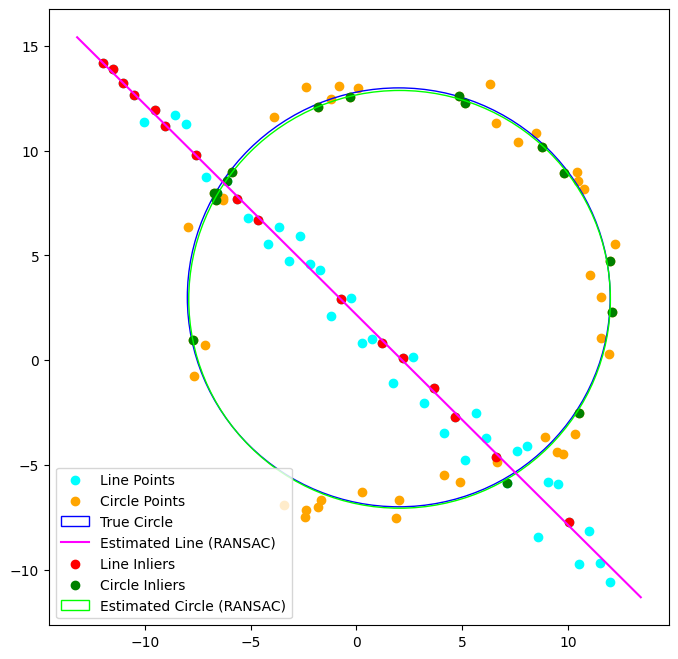

In [46]:
import numpy as np
import math

import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(1)

# Number of points
total_points = 100
half_points = total_points // 2

# Ground truth for the circle
circle_radius = 10
circle_center_x, circle_center_y = 2, 3  # Center of the circle
circle_noise_scale = circle_radius / 16

# Generate points for the circle
theta_values = np.random.uniform(0, 2 * np.pi, half_points)
noise_values = circle_noise_scale * np.random.randn(half_points)
x_circle_points = circle_center_x + (circle_radius + noise_values) * np.cos(theta_values)
y_circle_points = circle_center_y + (circle_radius + noise_values) * np.sin(theta_values)
circle_points = np.column_stack((x_circle_points, y_circle_points))

# Generate points for the line
line_noise_scale = 1.0
line_slope, line_intercept = -1, 2

x_line_points = np.linspace(-12, 12, half_points)
y_line_points = line_slope * x_line_points + line_intercept + line_noise_scale * np.random.randn(half_points)
line_points = np.column_stack((x_line_points, y_line_points))

# Concatenate points from both the circle and the line to create the full dataset
all_points = np.vstack((circle_points, line_points))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(line_points[:, 0], line_points[:, 1], color='cyan', label='Line Points')
ax.scatter(circle_points[:, 0], circle_points[:, 1], color='orange', label='Circle Points')
true_circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, color='blue', fill=False, label='True Circle')
ax.add_artist(true_circle)
x_min_val, x_max_val = ax.get_xlim()
x_range_vals = np.array([x_min_val, x_max_val])
y_range_vals = line_slope * x_range_vals + line_intercept

# Define a function to calculate the line equation from two points
def line_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(points, iterations, threshold, min_inliers):
    best_line_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(points), 2, replace=False)
        x1, y1 = points[sample_indices[0]]
        x2, y2 = points[sample_indices[1]]
        
        a, b, d = line_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a*points[:, 0] + b*points[:, 1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_line_model = (a, b, d)
                best_inliers = inliers
                
    return best_line_model, best_inliers

# RANSAC parameters for line estimation
iterations = 10000
line_threshold = 0.15
min_line_inliers = 15

# Estimate the line using RANSAC
best_line_model, line_inliers = ransac_line(line_points, iterations, line_threshold, min_line_inliers)

print("Number of inliers for the line:", len(line_inliers))
print("Parameters of the estimated line:")
print(f"a: {best_line_model[0]}")
print(f"b: {best_line_model[1]}")
print(f"d: {best_line_model[2]}")

# Define a function to calculate the circle equation from three points
def circle_from_points(x1, y1, x2, y2, x3, y3):
    # Calculate the midpoints of two line segments
    midpoint1_x, midpoint1_y = (x1 + x2) / 2, (y1 + y2) / 2
    midpoint2_x, midpoint2_y = (x2 + x3) / 2, (y2 + y3) / 2
    
    # Calculate the slopes of the two lines
    if y2 - y1 == 0:
        slope1 = 0  # Avoid division by zero
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0  # Avoid division by zero
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    # Calculate the center of the circle
    center_x = (slope1 * midpoint1_x - slope2 * midpoint2_x + midpoint2_y - midpoint1_y) / (slope1 - slope2)
    center_y = -slope1 * (center_x - midpoint1_x) + midpoint1_y
    
    # Calculate the radius
    radius = np.sqrt((x1 - center_x)**2 + (y1 - center_y)**2)
    
    return center_x, center_y, radius

# RANSAC to fit a circle
def ransac_circle(points, iterations, threshold, min_inliers):
    best_circle_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        x1, y1 = points[sample_indices[0]]
        x2, y2 = points[sample_indices[1]]
        x3, y3 = points[sample_indices[2]]
        
        center_x, center_y, radius = circle_from_points(x1, y1, x2, y2, x3, y3)
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((points[:, 0] - center_x)**2 + (points[:, 1] - center_y)**2) - radius)
        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_circle_model = (center_x, center_y, radius)
                best_inliers = inliers
                
    return best_circle_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2
min_circle_inliers = 15

# Identify the remnant points (points not explained by the line)
remnant_indices = [i for i in range(len(all_points)) if i not in line_inliers]
remnant_points = all_points[remnant_indices]

# Estimate the circle using RANSAC
best_circle_model, circle_inliers = ransac_circle(remnant_points, circle_iterations, circle_threshold, min_circle_inliers)

print("Number of inliers for the circle:", len(circle_inliers))
print("Parameters of the estimated circle:")
print(f"x_center: {best_circle_model[0]}")
print(f"y_center: {best_circle_model[1]}")
print(f"radius: {best_circle_model[2]}")

# Plot the estimated line
x_min_val, x_max_val = ax.get_xlim()
x_range_vals = np.array([x_min_val, x_max_val])
y_range_vals = (-best_line_model[0] * x_range_vals + best_line_model[2]) / best_line_model[1]
plt.plot(x_range_vals, y_range_vals, label='Estimated Line (RANSAC)', color='magenta')

# Plot the inliers of the line
ax.scatter(line_points[line_inliers, 0], line_points[line_inliers, 1], color='red', label='Line Inliers')

# Plot the inliers of the circle
ax.scatter(remnant_points[circle_inliers, 0], remnant_points[circle_inliers, 1], color='green', label='Circle Inliers')

# Plot the estimated circle
estimated_circle = plt.Circle((best_circle_model[0], best_circle_model[1]), best_circle_model[2], color='lime', fill=False, label='Estimated Circle (RANSAC)')
ax.add_artist(estimated_circle)

plt.legend()
plt.show()

Number of inliers for the line: 16
Parameters of the estimated line:
a: 0.7080986693010423
b: 0.7061134997534697
d: 1.5303717301982513
Number of inliers for the circle: 16
Parameters of the estimated circle:
x_center: 2.0388812056906938
y_center: 2.905374551155992
radius: 9.971739443086292


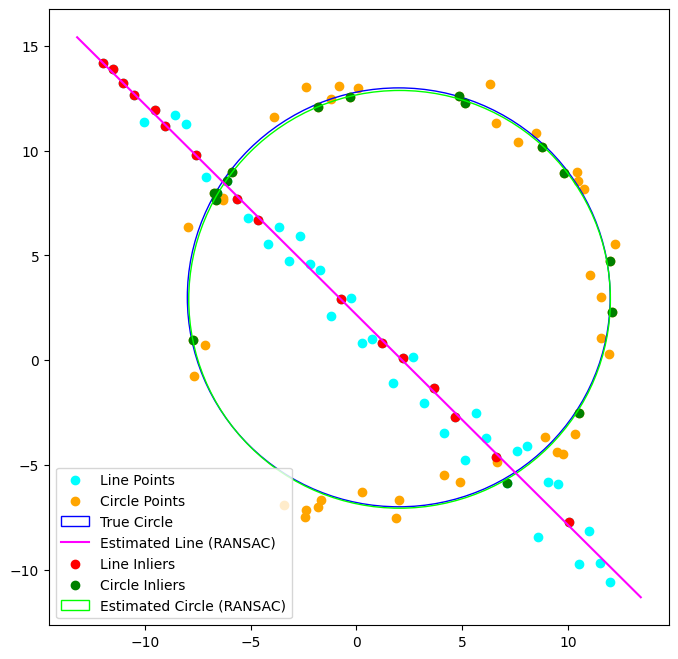

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Seed for reproducibility
np.random.seed(1)

# Number of points
total_points = 100
half_points = total_points // 2

# Ground truth for the circle
circle_radius = 10
circle_center_x, circle_center_y = 2, 3  # Center of the circle
circle_noise_scale = circle_radius / 16

# Generate points for the circle
theta_values = np.random.uniform(0, 2 * np.pi, half_points)
noise_values = circle_noise_scale * np.random.randn(half_points)
x_circle_points = circle_center_x + (circle_radius + noise_values) * np.cos(theta_values)
y_circle_points = circle_center_y + (circle_radius + noise_values) * np.sin(theta_values)
circle_points = np.column_stack((x_circle_points, y_circle_points))

# Generate points for the line
line_noise_scale = 1.0
line_slope, line_intercept = -1, 2

x_line_points = np.linspace(-12, 12, half_points)
y_line_points = line_slope * x_line_points + line_intercept + line_noise_scale * np.random.randn(half_points)
line_points = np.column_stack((x_line_points, y_line_points))

# Concatenate points from both the circle and the line to create the full dataset
all_points = np.vstack((circle_points, line_points))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(line_points[:, 0], line_points[:, 1], color='cyan', label='Line Points')
ax.scatter(circle_points[:, 0], circle_points[:, 1], color='orange', label='Circle Points')
true_circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, color='blue', fill=False, label='True Circle')
ax.add_artist(true_circle)
x_min_val, x_max_val = ax.get_xlim()
x_range_vals = np.array([x_min_val, x_max_val])
y_range_vals = line_slope * x_range_vals + line_intercept

# Define a function to calculate the line equation from two points
def line_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(points, iterations, threshold, min_inliers):
    best_line_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(points), 2, replace=False)
        x1, y1 = points[sample_indices[0]]
        x2, y2 = points[sample_indices[1]]
        
        a, b, d = line_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a*points[:, 0] + b*points[:, 1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_line_model = (a, b, d)
                best_inliers = inliers
                
    return best_line_model, best_inliers

# RANSAC parameters for line estimation
iterations = 10000
line_threshold = 0.15
min_line_inliers = 15

# Estimate the line using RANSAC
best_line_model, line_inliers = ransac_line(line_points, iterations, line_threshold, min_line_inliers)

print("Number of inliers for the line:", len(line_inliers))
print("Parameters of the estimated line:")
print(f"a: {best_line_model[0]}")
print(f"b: {best_line_model[1]}")
print(f"d: {best_line_model[2]}")

# Define a function to calculate the circle equation from three points
def circle_from_points(x1, y1, x2, y2, x3, y3):
    # Calculate the midpoints of two line segments
    midpoint1_x, midpoint1_y = (x1 + x2) / 2, (y1 + y2) / 2
    midpoint2_x, midpoint2_y = (x2 + x3) / 2, (y2 + y3) / 2
    
    # Calculate the slopes of the two lines
    if y2 - y1 == 0:
        slope1 = 0  # Avoid division by zero
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0  # Avoid division by zero
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    # Calculate the center of the circle
    center_x = (slope1 * midpoint1_x - slope2 * midpoint2_x + midpoint2_y - midpoint1_y) / (slope1 - slope2)
    center_y = -slope1 * (center_x - midpoint1_x) + midpoint1_y
    
    # Calculate the radius
    radius = np.sqrt((x1 - center_x)**2 + (y1 - center_y)**2)
    
    return center_x, center_y, radius

# RANSAC to fit a circle
def ransac_circle(points, iterations, threshold, min_inliers):
    best_circle_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        x1, y1 = points[sample_indices[0]]
        x2, y2 = points[sample_indices[1]]
        x3, y3 = points[sample_indices[2]]
        
        center_x, center_y, radius = circle_from_points(x1, y1, x2, y2, x3, y3)
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((points[:, 0] - center_x)**2 + (points[:, 1] - center_y)**2) - radius)
        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_circle_model = (center_x, center_y, radius)
                best_inliers = inliers
                
    return best_circle_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2
min_circle_inliers = 15

# Identify the remnant points (points not explained by the line)
remnant_indices = [i for i in range(len(all_points)) if i not in line_inliers]
remnant_points = all_points[remnant_indices]

# Estimate the circle using RANSAC
best_circle_model, circle_inliers = ransac_circle(remnant_points, circle_iterations, circle_threshold, min_circle_inliers)

print("Number of inliers for the circle:", len(circle_inliers))
print("Parameters of the estimated circle:")
print(f"x_center: {best_circle_model[0]}")
print(f"y_center: {best_circle_model[1]}")
print(f"radius: {best_circle_model[2]}")

# Plot the estimated line
x_min_val, x_max_val = ax.get_xlim()
x_range_vals = np.array([x_min_val, x_max_val])
y_range_vals = (-best_line_model[0] * x_range_vals + best_line_model[2]) / best_line_model[1]
plt.plot(x_range_vals, y_range_vals, label='Estimated Line (RANSAC)', color='magenta')

# Plot the inliers of the line
ax.scatter(line_points[line_inliers, 0], line_points[line_inliers, 1], color='red', label='Line Inliers')

# Plot the inliers of the circle
ax.scatter(remnant_points[circle_inliers, 0], remnant_points[circle_inliers, 1], color='green', label='Circle Inliers')

# Plot the estimated circle
estimated_circle = plt.Circle((best_circle_model[0], best_circle_model[1]), best_circle_model[2], color='lime', fill=False, label='Estimated Circle (RANSAC)')
ax.add_artist(estimated_circle)

plt.legend()
plt.show()
